<a href="https://colab.research.google.com/github/insanebaba/Deep-Learning-Book-Chapter-Summaries/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Create 98% accurate pneumonia detector for [kaggle competition](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

**This is an easy to use notebook you can run on google colab**



*All you need is a kaggle username and token*

you can learn on how to generate one at [Kaggle CLI authentication](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication)

In [0]:
#   !curl -s https://course.fast.ai/setup/colab | bash
from fastai.vision import *
from fastai.metrics import *
from pathlib import *
from pathlib import Path
import os 
home = os.getcwd()
home

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# !ls
!rm -rf $home/sample_data
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"username","key":"password"}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
# !rm -rf /Content/
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qo chest-xray-pneumonia.zip -d $home && rm -rf chest-xray-pneumonia.zip
!unzip -qo ./chest_xray.zip -d $home && rm ./chest_xray.zip
# !ls -lapr --block-size=M ./chest_xray


mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 1.15G/1.15G [00:05<00:00, 198MB/s]



In [0]:
!rm -f *.zip
# !ls -lapr --block-size=M $home/chest_xray
!find -type f -name ".DS_Store*" -delete
!rm -rf __MACOSX
!ls -lap
# !ls -lapr --block-size=M ./chest_xray
# path=Path("./chest_xray")
# path
# !ls -lapr --block-size=M ./chest_xray
# !pwd
# !ls -lapr --block-size=M /Content/

total 1M
drwxr-xr-x 4 root root 1M Jul 14 12:49 val/
drwxr-xr-x 4 root root 1M Jul 14 12:49 train/
drwxr-xr-x 4 root root 1M Jul 14 12:49 test/
drwxr-xr-x 2 root root 1M Jul 14 12:42 model/
drwxr-xr-x 1 root root 1M Jul 14 12:49 ../
drwxr-xr-x 6 root root 1M Jul 14 12:49 ./
total 20
drwxr-xr-x 1 root root 4096 Jul 14 12:52 ./
drwxr-xr-x 1 root root 4096 Jul 14 12:22 ../
drwxr-xr-x 6 root root 4096 Jul 14 12:49 chest_xray/
drwxr-xr-x 1 root root 4096 Jul 11 16:05 .config/


In [0]:
path=Path(home+"/chest_xray")
path
path_train=path/"train"
path_valid=path/"val"
path_test=path/"test"

In [0]:
print(path_train.ls())
print(path_valid.ls())
print(path_test.ls())

[PosixPath('/content/chest_xray/train/PNEUMONIA'), PosixPath('/content/chest_xray/train/NORMAL')]
[PosixPath('/content/chest_xray/val/PNEUMONIA'), PosixPath('/content/chest_xray/val/NORMAL')]
[PosixPath('/content/chest_xray/test/PNEUMONIA'), PosixPath('/content/chest_xray/test/NORMAL')]


# Create Data

In [0]:
np.random.seed(41)

In [0]:
# extra_tfms = get_transforms(rand_resize_crop(224),zoom_crop(scale=(0.75,2), do_rand=True))
data=ImageDataBunch.from_folder(path,
             train="train", 
             valid="val",
             bs=128,
             ds_tfms=
                     get_transforms(do_flip=False
                                    ,max_rotate=30
#                                     ,max_warp=0.4
                                   ),
                                    size=256,
                                valid_pct=0.2,
                                num_workers=8).normalize(imagenet_stats)

# Start Data analysis

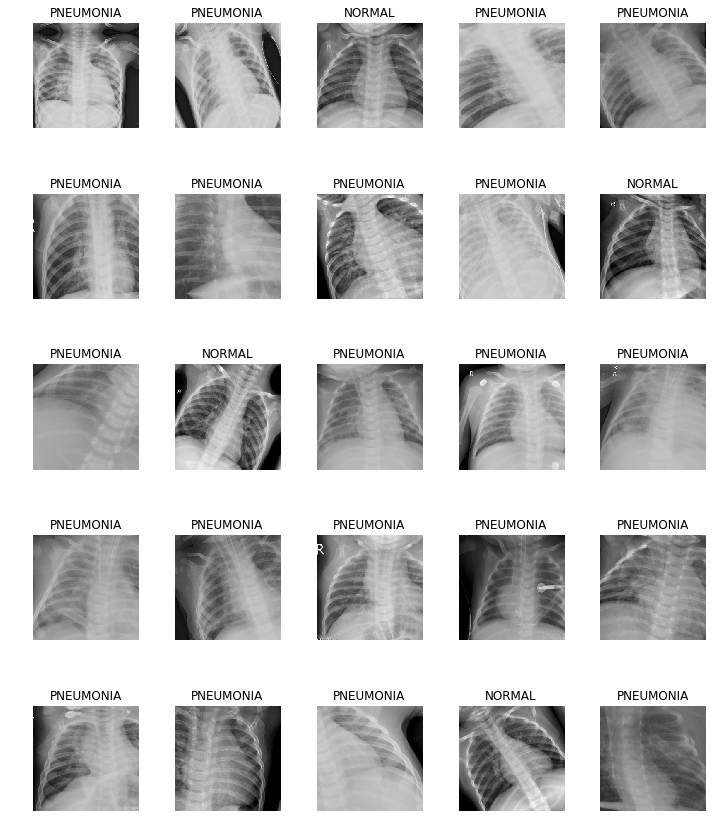

In [0]:
data.show_batch(row=2,figsize=(10,12))

In [0]:
print(data.classes)
len(data.classes),data.c

['NORMAL', 'PNEUMONIA']


(2, 2)

File: /content/chest_xray/train/PNEUMONIA/person579_bacteria_2386.jpeg



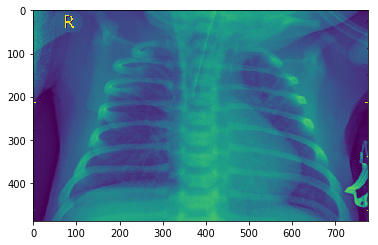

File: /content/chest_xray/train/PNEUMONIA/person1082_bacteria_3022.jpeg



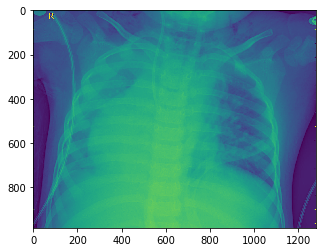

File: /content/chest_xray/train/PNEUMONIA/person313_bacteria_1460.jpeg



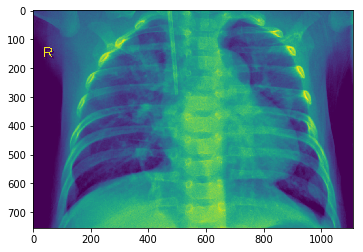

In [0]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#See test data
def display_photo(path):
    print("File: {}\n".format(path))
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
    
test_images=(path_test/"NORMAL").ls()+(path_test/"PNEUMONIA").ls()+\
(path_train/"NORMAL").ls()+(path_train/"PNEUMONIA").ls()+\
(path_valid/"NORMAL").ls()+(path_valid/"PNEUMONIA").ls()
for i in random.choices(test_images,k=3):
#   print(str(i))
   display_photo(i.absolute())


In [0]:
print(len((path_test/"NORMAL").ls()))
print(len((path_test/"PNEUMONIA").ls()))
print(len((path_train/"NORMAL").ls()))
print(len((path_train/"PNEUMONIA").ls()))
print(len((path_valid/"NORMAL").ls()))
print(len((path_valid/"PNEUMONIA").ls()))

234
390
1341
3875
8
8


# Define a Model

In [0]:
learner = cnn_learner(data, models.resnet18, metrics=[error_rate],model_dir=path/"model/")
# learner.summary()

# Train model

In [0]:
learner.fit_one_cycle(2)
learner.save("epoch-2")


epoch,train_loss,valid_loss,error_rate,time
0,0.442074,0.181057,0.060632,04:29
1,0.285069,0.169512,0.052946,04:28


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


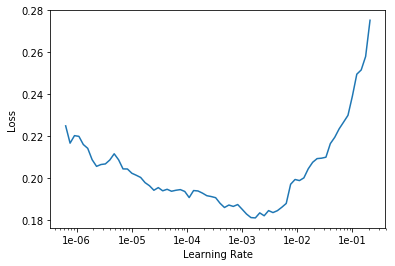

In [0]:
# doing it now as it gives error later after interop
learner.lr_find()
learner.recorder.plot()

## Analyse results

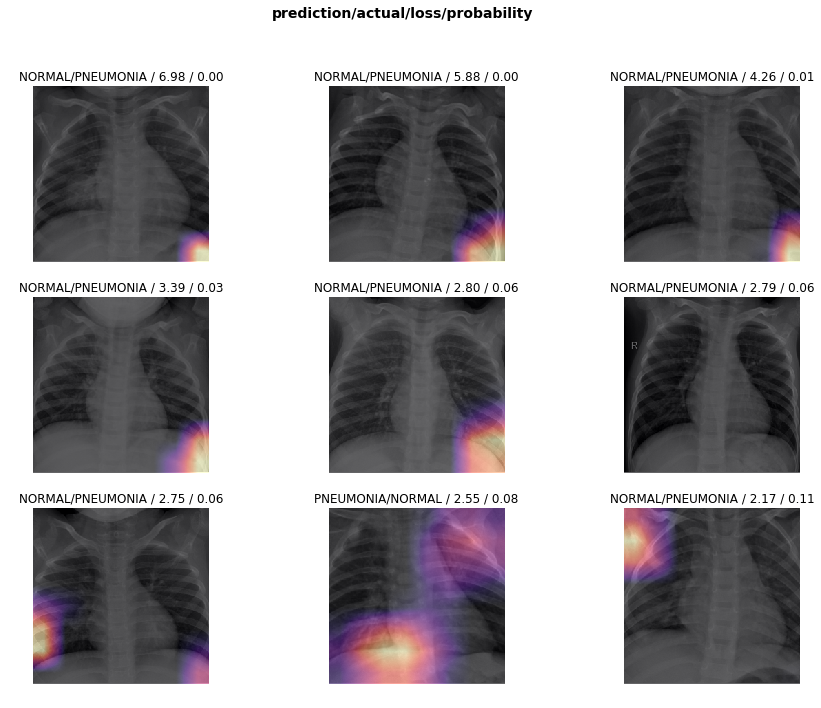

In [42]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

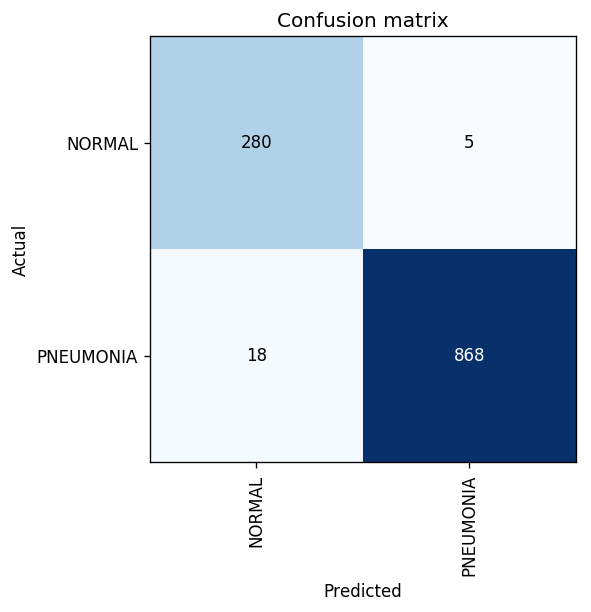

In [43]:
interp.plot_confusion_matrix(figsize=(8,5), dpi=120)

In [0]:
learner.unfreeze()

In [40]:

# learner.fit_one_cycle(2,max_lr=1e-3)
learner.fit_one_cycle(4,max_lr=slice(9e-4,2e-3))

learner.save("epoch-8")
# learner.fit_one_cycle(1,max_lr=1e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.173240,0.300836,0.096499,04:25
1,0.155821,0.203436,0.056362,04:26
2,0.122675,0.062772,0.019641,04:25
3,0.093093,0.063062,0.019641,04:26


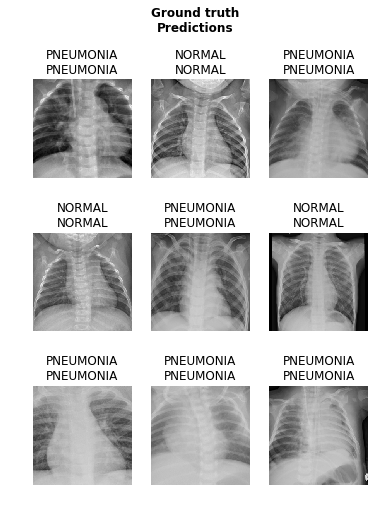

In [41]:
# learner.save("epoch5")
learner.show_results(rows=3,cols=8, figsize=(6,8),batch_size=32)

In [47]:
from google.colab import drive
m=drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:

learner.save("/content/drive/My Drive/Colab Notebooks/resnet_18_pneumonia")


# model_file = drive.CreateFile({'title' : 'resnet_18_pneumonia'})
# model_file.SetContentFile('resnet_18_pneumonia')
# model_file.Upload()


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
